In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
import seaborn as sns
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
import statsmodels.formula.api as smf
from sklearn.model_selection import cross_val_score
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import math

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
data = pd.read_csv("NYCrime.csv")
data.head(5)

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,861",0,0,nan,0,0,0,12,2,10,0,0.000
1,Addison Town and Village,"2,577",3,0,nan,0,0,3,24,3,20,1,0.000
2,Akron Village,"2,846",3,0,nan,0,0,3,16,1,15,0,0.000
3,Albany,"97,956",791,8,nan,30,227,526,"4,090",705,"3,243",142,nan
4,Albion Village,"6,388",23,0,nan,3,4,16,223,53,165,5,nan


In [3]:
data.rename(columns={'City':'city','Population':'population','Violent\ncrime':'vCrime',
                   'Murder and\nnonnegligent\nmanslaughter':'murder','Rape\n(revised\ndefinition)1':'rapeRev',
                   'Rape\n(legacy\ndefinition)2':'rape','Robbery':'robbery','Aggravated\nassault':'assault',
                   'Property\ncrime':'pCrime','Burglary':'burglary','Larceny-\ntheft':'larceny',
                   'Motor\nvehicle\ntheft':'mTheft','Arson3':'arson'}, inplace=True)

In [4]:
data['population'] = data.population.str.replace(',','').astype('float')
data['vCrime'] = data.vCrime.str.replace(',', '').astype('float')
data['murder'] = data.murder.astype('float')
data.drop(columns=['rapeRev'], inplace=True)
data['rape'] = data.rape.str.replace(',', '').astype('float')
data['robbery'] = data.robbery.str.replace(',', '').astype('float')
data['assault'] = data.assault.str.replace(',', '').astype('float')
data['pCrime'] = data.pCrime.str.replace(',', '').astype('float')
data['burglary'] = data.burglary.str.replace(',', '').astype('float')
data['larceny'] = data.larceny.str.replace(',', '').astype('float')
data['mTheft'] = data.mTheft.str.replace(',', '').astype('float')
data.drop(columns=['arson'], inplace=True)

In [5]:
data.dtypes

city           object
population    float64
vCrime        float64
murder        float64
rape          float64
robbery       float64
assault       float64
pCrime        float64
burglary      float64
larceny       float64
mTheft        float64
dtype: object

In [6]:
data.describe()

,population,vCrime,murder,rape,robbery,assault,pCrime,burglary,larceny,mTheft
count,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000
mean,40037.632,201.595,1.566,5.865,72.902,121.261,792.606,119.684,637.017,35.905
std,450037.368,2815.269,18.304,60.425,1031.033,1706.132,7659.725,924.949,6346.054,403.424
min,526.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,3003.000,2.000,0.000,0.000,0.000,1.000,40.500,6.000,31.000,0.000
50%,7233.500,6.000,0.000,0.000,1.000,4.000,112.500,17.500,94.000,2.000
75%,18427.500,22.000,0.000,2.000,5.000,14.000,341.000,51.250,287.250,7.000
max,8396126.000,52384.000,335.000,1112.000,19170.000,31767.000,141971.000,16606.000,117931.000,7434.000


In [7]:
#Remove Outliners in population. 75% looks about right

data = data[data.population < (np.percentile(data.population, 75))]

In [8]:
data.describe()

,population,vCrime,murder,rape,robbery,assault,pCrime,burglary,larceny,mTheft
count,261.000,261.000,261.000,261.000,261.000,261.000,261.000,261.000,261.000,261.000
mean,6071.218,8.080,0.054,0.705,1.632,5.690,119.345,19.226,97.736,2.383
std,4471.334,12.259,0.226,1.598,3.025,8.593,140.709,23.494,118.640,3.822
min,526.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2381.000,1.000,0.000,0.000,0.000,0.000,29.000,4.000,20.000,0.000
50%,4704.000,3.000,0.000,0.000,0.000,3.000,66.000,11.000,53.000,1.000
75%,8544.000,9.000,0.000,1.000,2.000,7.000,156.000,23.000,121.000,3.000
max,18182.000,89.000,1.000,13.000,20.000,64.000,949.000,138.000,828.000,35.000


In [9]:
# Perfect. Now lets do PCA for correlated crimes

# Take a subset of the data for PCA. they are the highest correlations after Larceny with Property crime. Also not included population 
data_pca = data[['vCrime','robbery','assault','burglary','larceny','mTheft']].dropna()
X = StandardScaler().fit_transform(data_pca)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)


In [10]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 6).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[[-0.44395397]
 [-0.4068537 ]
 [-0.4203554 ]
 [-0.42717071]
 [-0.40078549]
 [-0.3428884 ]]
Eigenvalue 1: 4.666116223272896
----------------------------------------
Eigenvector 2: 
[[ 0.77297677]
 [-0.18288499]
 [-0.60717557]
 [-0.01205869]
 [-0.01228471]
 [-0.0100747 ]]
Eigenvalue 2: 0.004278066505443268
----------------------------------------
Eigenvector 3: 
[[ 0.19019937]
 [ 0.09173857]
 [ 0.22494124]
 [ 0.10908028]
 [ 0.1431099 ]
 [-0.93404   ]]
Eigenvalue 3: 0.5178655237666728
----------------------------------------
Eigenvector 4: 
[[ 0.09071737]
 [ 0.32507681]
 [ 0.02540544]
 [-0.84153623]
 [ 0.42042053]
 [ 0.02265699]]
Eigenvalue 4: 0.15386239379298264
----------------------------------------
Eigenvector 5: 
[[ 0.40037309]
 [-0.26741829]
 [ 0.6061204 ]
 [-0.31188142]
 [-0.54490699]
 [ 0.08132191]]
Eigenvalue 5: 0.38309761853357666
----------------------------------------
Eigenvector 6: 
[[-0.02660323]
 [-0.7844869 ]
 [ 0.18977152]
 [-0.00529379]
 [ 0.58742027]
 

In [11]:
# Create P, which we will use to transform Cx into Cy to get Y, the
# dimensionally-reduced representation of X. Take only the first component
P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt)

#create a new df with the outcome variable and add Y as a feature
features = pd.DataFrame(data['pCrime'])

features['Crime'] = Y

#Add the root of population, which was also useful per the last assignment
features['sqrtPop'] = [math.sqrt(x) for x in data['population']]

In [12]:
features.head()

,pCrime,Crime,sqrtPop
0,12.000,1.617,43.139
1,24.000,1.219,50.764
2,16.000,1.362,53.348
4,223.000,-2.444,79.925
5,46.000,0.700,63.945


In [13]:
# Write out the model formula.
# Your dependent variable on the right, independent variables on the left
# Use a ~ to represent an '=' from the functional form
linear_formula = 'pCrime ~ Crime+sqrtPop'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=features).fit()

In [14]:
lm.params

Intercept    73.956
Crime       -53.573
sqrtPop       0.625
dtype: float64

In [15]:
lm.pvalues

Intercept   0.000
Crime       0.000
sqrtPop     0.000
dtype: float64

In [16]:
lm.rsquared

0.8235930948412724

In [17]:
lm.conf_int()

,0,1
Intercept,48.589,99.323
Crime,-57.936,-49.209
sqrtPop,0.290,0.959


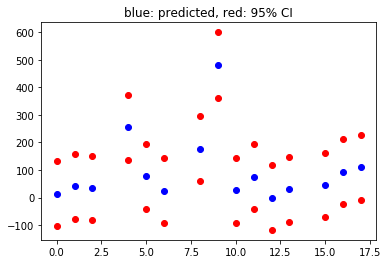

In [18]:
# Use wls_prediction_std to build confidence intervals
prstd, iv_l, iv_u = wls_prediction_std(lm)

plt.figure()
plt.plot(iv_u[0:15], 'o', color='r')
plt.plot(iv_l[0:15], 'o', color='r')
plt.plot(lm.fittedvalues[0:15], 'o', color='b')
plt.title('blue: predicted, red: 95% CI')
plt.show()

## Hold out method 

In [19]:
# Instantiate and fit model

regr = linear_model.LinearRegression()
Y = features['pCrime'].values.reshape(-1, 1)
X = features[['Crime','sqrtPop']]
regr.fit(X, Y)

# Inspect the results

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[-53.57283806   0.62460323]]

Intercept: 
 [73.95590737]

R-squared:
0.8235930948412725


In [20]:
data = features[['Crime'] + ['sqrtPop']]
target = features['pCrime']

y_pred = regr.fit(data, target).predict(data)

In [21]:
# Test your model with different holdout groups.

from sklearn.model_selection import train_test_split

# Use train_test_split to create the necessary training and test groups

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(data, target).score(data, target)))

With 20% Holdout: 0.8827451202988555
Testing on Sample: 0.8235930948412725


In [22]:
#Cross Validation

cross_val_score(regr, data, target, cv=5)

array([0.86309247, 0.85639215, 0.76932076, 0.87126878, 0.56656663])

## Model on 2014 NY data

In [23]:
data2014 = pd.read_csv("NYCrime2014.csv")
data2014.head(5)

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,851",0,0.000,NaN,0.000,0,0,11,1,10,0,0.000
1,Addison Town and Village,"2,568",2,0.000,NaN,0.000,1,1,49,1,47,1,0.000
2,Afton Village4,820,0,0.000,0,nan,0,0,1,0,1,0,0.000
3,Akron Village,"2,842",1,0.000,NaN,0.000,0,1,17,0,17,0,0.000
4,Albany4,"98,595",802,8.000,54,nan,237,503,"3,888",683,"3,083",122,12.000


In [24]:
data2014.rename(columns={'City':'city','Population':'population','Violent\ncrime':'vCrime',
                   'Murder and\nnonnegligent\nmanslaughter':'murder','Rape\n(revised\ndefinition)1':'rapeRev',
                   'Rape\n(legacy\ndefinition)2':'rape','Robbery':'robbery','Aggravated\nassault':'assault',
                   'Property\ncrime':'pCrime','Burglary':'burglary','Larceny-\ntheft':'larceny',
                   'Motor\nvehicle\ntheft':'mTheft','Arson3':'arson'}, inplace=True)

In [25]:
data2014.head(5)

,city,population,vCrime,murder,rapeRev,rape,robbery,assault,pCrime,burglary,larceny,mTheft,arson
0,Adams Village,"1,851",0,0.000,NaN,0.000,0,0,11,1,10,0,0.000
1,Addison Town and Village,"2,568",2,0.000,NaN,0.000,1,1,49,1,47,1,0.000
2,Afton Village4,820,0,0.000,0,nan,0,0,1,0,1,0,0.000
3,Akron Village,"2,842",1,0.000,NaN,0.000,0,1,17,0,17,0,0.000
4,Albany4,"98,595",802,8.000,54,nan,237,503,"3,888",683,"3,083",122,12.000


In [26]:
data2014.dtypes

city           object
population     object
vCrime         object
murder        float64
rapeRev        object
rape          float64
robbery        object
assault        object
pCrime         object
burglary       object
larceny        object
mTheft         object
arson         float64
dtype: object

In [27]:
data2014['population'] = data2014.population.str.replace(',','').astype('float')
data2014['vCrime'] = data2014.vCrime.str.replace(',', '').astype('float')
data2014['murder'] = data2014.murder.astype('float')
data2014.drop(columns=['rapeRev'], inplace=True)
data2014['robbery'] = data2014.robbery.str.replace(',', '').astype('float')
data2014['assault'] = data2014.assault.str.replace(',', '').astype('float')
data2014['pCrime'] = data2014.pCrime.str.replace(',', '').astype('float')
data2014['burglary'] = data2014.burglary.str.replace(',', '').astype('float')
data2014['larceny'] = data2014.larceny.str.replace(',', '').astype('float')
data2014['mTheft'] = data2014.mTheft.str.replace(',', '').astype('float')
data2014.drop(columns=['arson'], inplace=True)

In [28]:
data2014.dtypes

city           object
population    float64
vCrime        float64
murder        float64
rape          float64
robbery       float64
assault       float64
pCrime        float64
burglary      float64
larceny       float64
mTheft        float64
dtype: object

In [29]:
data2014.describe()

,population,vCrime,murder,rape,robbery,assault,pCrime,burglary,larceny,mTheft
count,369.000,369.000,369.000,142.000,369.000,369.000,368.000,369.000,368.000,369.000
mean,37814.824,183.691,1.453,0.007,60.661,112.005,698.361,100.900,562.791,34.317
std,441159.058,2638.842,17.694,0.084,866.481,1640.515,7123.614,855.103,5869.850,406.957
min,79.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2631.000,1.000,0.000,0.000,0.000,0.000,25.000,4.000,20.000,0.000
50%,6581.000,5.000,0.000,0.000,1.000,3.000,76.000,12.000,60.500,2.000
75%,15408.000,18.000,0.000,0.000,4.000,12.000,271.500,39.000,228.500,6.000
max,8473938.000,50564.000,333.000,1.000,16581.000,31460.000,135747.000,15916.000,112107.000,7724.000


In [30]:
#Remove Outliners in population. 75% looks about right

dataNYC = data2014[data2014.population <= 15408]


In [31]:
dataNYC.describe()

,population,vCrime,murder,rape,robbery,assault,pCrime,burglary,larceny,mTheft
count,277.000,277.000,277.000,117.000,277.000,277.000,276.000,277.000,276.000,277.000
mean,5318.076,6.682,0.040,0.000,1.300,4.505,90.007,14.079,73.953,1.935
std,3889.046,11.186,0.213,0.000,2.873,7.568,126.839,19.820,107.620,2.846
min,79.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2179.000,0.000,0.000,0.000,0.000,0.000,17.000,2.000,12.000,0.000
50%,4032.000,2.000,0.000,0.000,0.000,2.000,44.000,7.000,37.000,1.000
75%,7958.000,8.000,0.000,0.000,1.000,6.000,112.500,17.000,91.000,3.000
max,15408.000,75.000,2.000,0.000,23.000,48.000,1090.000,132.000,950.000,16.000


In [32]:
dataNYC.isnull().sum()

city            0
population      0
vCrime          0
murder          0
rape          160
robbery         0
assault         0
pCrime          1
burglary        0
larceny         1
mTheft          0
dtype: int64

In [33]:
dataNYC.drop(columns=['rape'], inplace=True)
dataNYC.dropna(subset=['pCrime'], inplace=True)
dataNYC.dropna(subset=['larceny'], inplace=True)

c:\users\bharath\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
c:\users\bharath\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\bharath\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel p

In [34]:
# Perfect. Now lets do PCA for correlated crimes

# Take a subset of the data for PCA. they are the highest correlations after Larceny with Property crime. Also not included population 
dataNYC_pca = dataNYC[['vCrime','robbery','assault','burglary','larceny','mTheft']]
X = StandardScaler().fit_transform(dataNYC_pca)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)


In [35]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 6).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[[-0.44541365]
 [-0.39929704]
 [-0.42732792]
 [-0.42954087]
 [-0.40958158]
 [-0.32756215]]
Eigenvalue 1: 4.627702488851323
----------------------------------------
Eigenvector 2: 
[[-0.25183887]
 [-0.08166713]
 [-0.30071276]
 [-0.13916623]
 [ 0.09273197]
 [ 0.90084019]]
Eigenvalue 2: 0.5962392109349578
----------------------------------------
Eigenvector 3: 
[[-0.78074683]
 [ 0.17698297]
 [ 0.59718839]
 [ 0.04946004]
 [-0.00243759]
 [ 0.0050205 ]]
Eigenvalue 3: 0.014425505025648275
----------------------------------------
Eigenvector 4: 
[[-0.19794816]
 [-0.60662532]
 [-0.10640183]
 [ 0.37806258]
 [ 0.64414985]
 [-0.15375482]]
Eigenvalue 4: 0.3933246377539708
----------------------------------------
Eigenvector 5: 
[[-0.28960526]
 [ 0.65037223]
 [-0.58403106]
 [ 0.18784823]
 [ 0.26538564]
 [-0.21525796]]
Eigenvalue 5: 0.27251914231353563
----------------------------------------
Eigenvector 6: 
[[-0.07458937]
 [-0.1076618 ]
 [-0.13384723]
 [ 0.78451439]
 [-0.58161774]
 [

In [36]:
# Create P, which we will use to transform Cx into Cy to get Y, the
# dimensionally-reduced representation of X. Take only the first component
P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt)

#create a new df with the outcome variable and add Y as a feature
featuresNYC = pd.DataFrame(dataNYC['pCrime'])


featuresNYC['Crime'] = Y

#Add the root of population, which was also useful per the last assignment
featuresNYC['sqrtPop'] = [math.sqrt(x) for x in dataNYC['population']]

In [37]:
# Write out the model formula.
# Your dependent variable on the right, independent variables on the left
# Use a ~ to represent an '=' from the functional form
linear_formula = 'pCrime ~ Crime+sqrtPop'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=featuresNYC).fit()

In [38]:
print(lm.params)
print(lm.pvalues)
print("R-squared",lm.rsquared)
lm.conf_int()

Intercept    64.379
Crime       -50.550
sqrtPop       0.378
dtype: float64
Intercept   0.000
Crime       0.000
sqrtPop     0.016
dtype: float64
R-squared 0.8252362711059853


,0,1
Intercept,42.599,86.160
Crime,-54.312,-46.788
sqrtPop,0.070,0.685


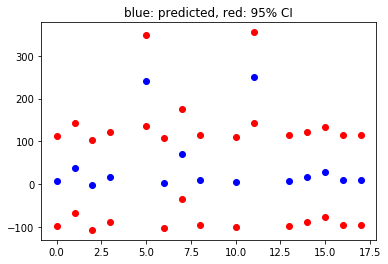

In [39]:
# Use wls_prediction_std to build confidence intervals
prstd, iv_l, iv_u = wls_prediction_std(lm)

plt.figure()
plt.plot(iv_u[0:15], 'o', color='r')
plt.plot(iv_l[0:15], 'o', color='r')
plt.plot(lm.fittedvalues[0:15], 'o', color='b')
plt.title('blue: predicted, red: 95% CI')
plt.show()

In [40]:
# Instantiate and fit model

regr = linear_model.LinearRegression()
Y = featuresNYC['pCrime'].values.reshape(-1, 1)
X = featuresNYC[['Crime','sqrtPop']]
regr.fit(X, Y)

# Inspect the results

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[-50.55028765   0.37758976]]

Intercept: 
 [64.37922318]

R-squared:
0.8252362711059853


In [41]:
data = featuresNYC[['Crime'] + ['sqrtPop']]
target = featuresNYC['pCrime']

y_pred = regr.fit(data, target).predict(data)

In [42]:
# Test your model with different holdout groups.

from sklearn.model_selection import train_test_split

# Use train_test_split to create the necessary training and test groups

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(data, target).score(data, target)))

With 20% Holdout: 0.7078145328431031
Testing on Sample: 0.8252362711059853


In [43]:
#Cross Validation
cross_val_score(regr, data, target, cv=5)

array([0.84074468, 0.86441617, 0.75459201, 0.81946054, 0.7756505 ])

## Conclusion

Our model gives around 82% accuracy for both NY 2013 and NY 2014 crime data. One significant difference being our model working with holdout groups for the two data. We saw that the 20% holdout group had accuracy of 88% for NYC 2013 where as it was 70% for NYC 2014 crime data. Also there is a lot of fluctuation in accuracy scores for cross validation for NYC 2013 crime data (56% to 86%) when compared to NYC 2014 crime data(75% to 86%)